Temporal: operations on the whole trace

Complex trace attributes were introduced into geophysics by the paper
Taner, M. T., F. Koehler, and R. E. Sheriff, 1979, Complex seismic trace analysis: Geophysics, 44, 1041-1063.
http://www.reproducibility.org/rsflog/index.php?/archives/274-Program-of-the-month-sfenvelope.html
If s(t) is the input seismic trace, then the analytical trace is defined as the complex valued signal

In [21]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [22]:
data = np.load('../data/data3d.npy')

In [23]:
data.shape

(194, 299, 450)

In [24]:
from IPython.display import Math

In [25]:
Math(r'a(t) = s(t)+ih(t)')

<IPython.core.display.Math object>

where h(t) is the Hilbert transform of s(t)

In [26]:
Math( r'h(t)= \frac{1}{\pi} \int \frac{ s \left( t \right)}{ t - \tau } d\tau' )


<IPython.core.display.Math object>

The signal envelop is the positive signal


In [27]:
Math(r'e\left ( t \right )=\sqrt{s^{2}\left ( t \right )+h^{2}\left ( t \right )}')


<IPython.core.display.Math object>

A phase rotated seismic signal is


In [28]:
Math(r'p\left ( t \right )=s\left ( t \right )cos\phi + h\left ( t \right )sin\phi')

<IPython.core.display.Math object>

In [29]:
from scipy.signal import hilbert

def envelope( s ):
    """
    Computes the envelope of a signal:
    :params s: The signal.
    :returns: envelope of signal
    """
    return abs(hilbert(s))

def rotate_phase( s, phi ):
    """
    Performs a phase rotation of wavelet using:
    A = w(t)Cos(phi) + h(t)Sin(phi)
    Where w(t) is the wavelet and h(t) is it's hilbert transform.
    
    :params s: The signal.
    :params phi: The phase rotation angle (in Radians) to apply.

    :returns: The phase rotated signal.
    """

    # Get the analytic signal for the wavelet
    a = hilbert( s )

    A = (np.real( a ) * np.cos( phi ) +
         np.imag( a  ) * np.sin( phi ) )

    return A
    
def ricker(f = 20, nsamps = 512, sr = 0.001):
    """
    f: frequency in Hz
    nsamps  :number of samples in the wavelet
    sr : sample rate in seconds
    """
    w = nsamps * sr # window length in seconds
    tw = np.linspace(-1*np.floor(nsamps/2)*sr, np.floor(nsamps/2)*sr, nsamps)
    term = np.pi*np.pi*f*f*tw*tw
    r = (1.0-2.0*term)*np.exp(-term)
    return r, tw

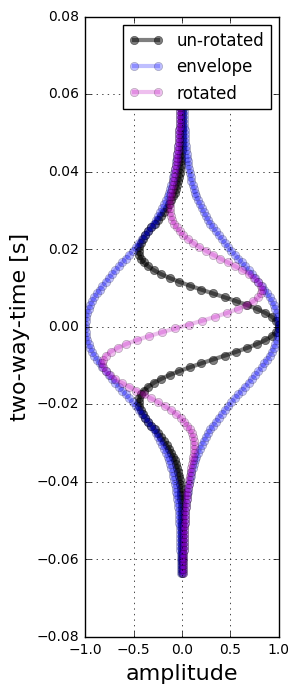

In [30]:
phi = np.pi/2.0
sig, tw = ricker()
rot_sig = rotate_phase(sig, phi)
env_sig = envelope(sig)

tcrop = 192
fig_env2 = plt.figure(figsize=[2.5,8])
ax3 = fig_env2.add_subplot(111)
ax3.plot( sig[tcrop:-tcrop],tw[tcrop:-tcrop],'ko-', lw=3, alpha=0.5, label = 'un-rotated')
ax3.plot( env_sig[tcrop:-tcrop],tw[tcrop:-tcrop],'bo-', lw=3, alpha=0.25, label = 'envelope')
ax3.plot( -1.0*env_sig[tcrop:-tcrop],tw[tcrop:-tcrop],'bo-', lw=3, alpha=0.25)
ax3.plot( rot_sig[tcrop:-tcrop],tw[tcrop:-tcrop],'mo-', lw=3, alpha=0.25, label = 'rotated')

ax3.set_ylabel('two-way-time [s]', fontsize=16)
ax3.set_xlabel('amplitude', fontsize=16)
ax3.grid()
ax3.legend()

# Make a plot of the real trace, the envelope, a +90 degree phase rotated trace.

In [48]:
s = data[150,150,:]

In [51]:
data.shape

(194, 299, 450)

In [52]:
dt = 0.004
t = np.arange(data.shape[-1])*dt

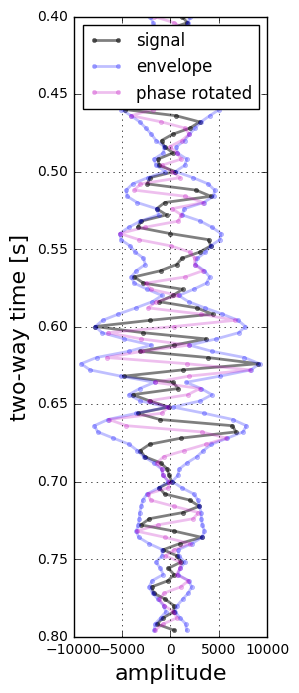

In [55]:
phi = np.pi / 2.0 # 90 degrees in radians
e = envelope(s)
s90 = rotate_phase(s, phi)
i = 100
f = 200

fig_env = plt.figure(figsize = (2.5,8), facecolor='w')
ax2 = fig_env.add_subplot(111)
ax2.plot( s[i:f], t[i:f],'k.-', lw=2, alpha = 0.5, label = 'signal')
ax2.plot( e[i:f], t[i:f],'b.-', lw = 2, alpha = 0.25,label = 'envelope')
ax2.plot( -1*e[i:f], t[i:f], 'b.-', lw = 2, alpha = 0.25)
ax2.plot( s90[i:f], t[i:f], 'm.-', lw = 2, alpha = 0.25, label = 'phase rotated')
ax2.legend()
ax2.set_xlabel('amplitude', fontsize = 16)
ax2.set_ylabel('two-way time [s]', fontsize = 16)
ax2.invert_yaxis()
ax2.grid()



# Do envelope for entire line

In [61]:
line = data[150,:,:]
vmin, vmax = -1e4, 1e4
line_ext = [0, 100, 0, 450]

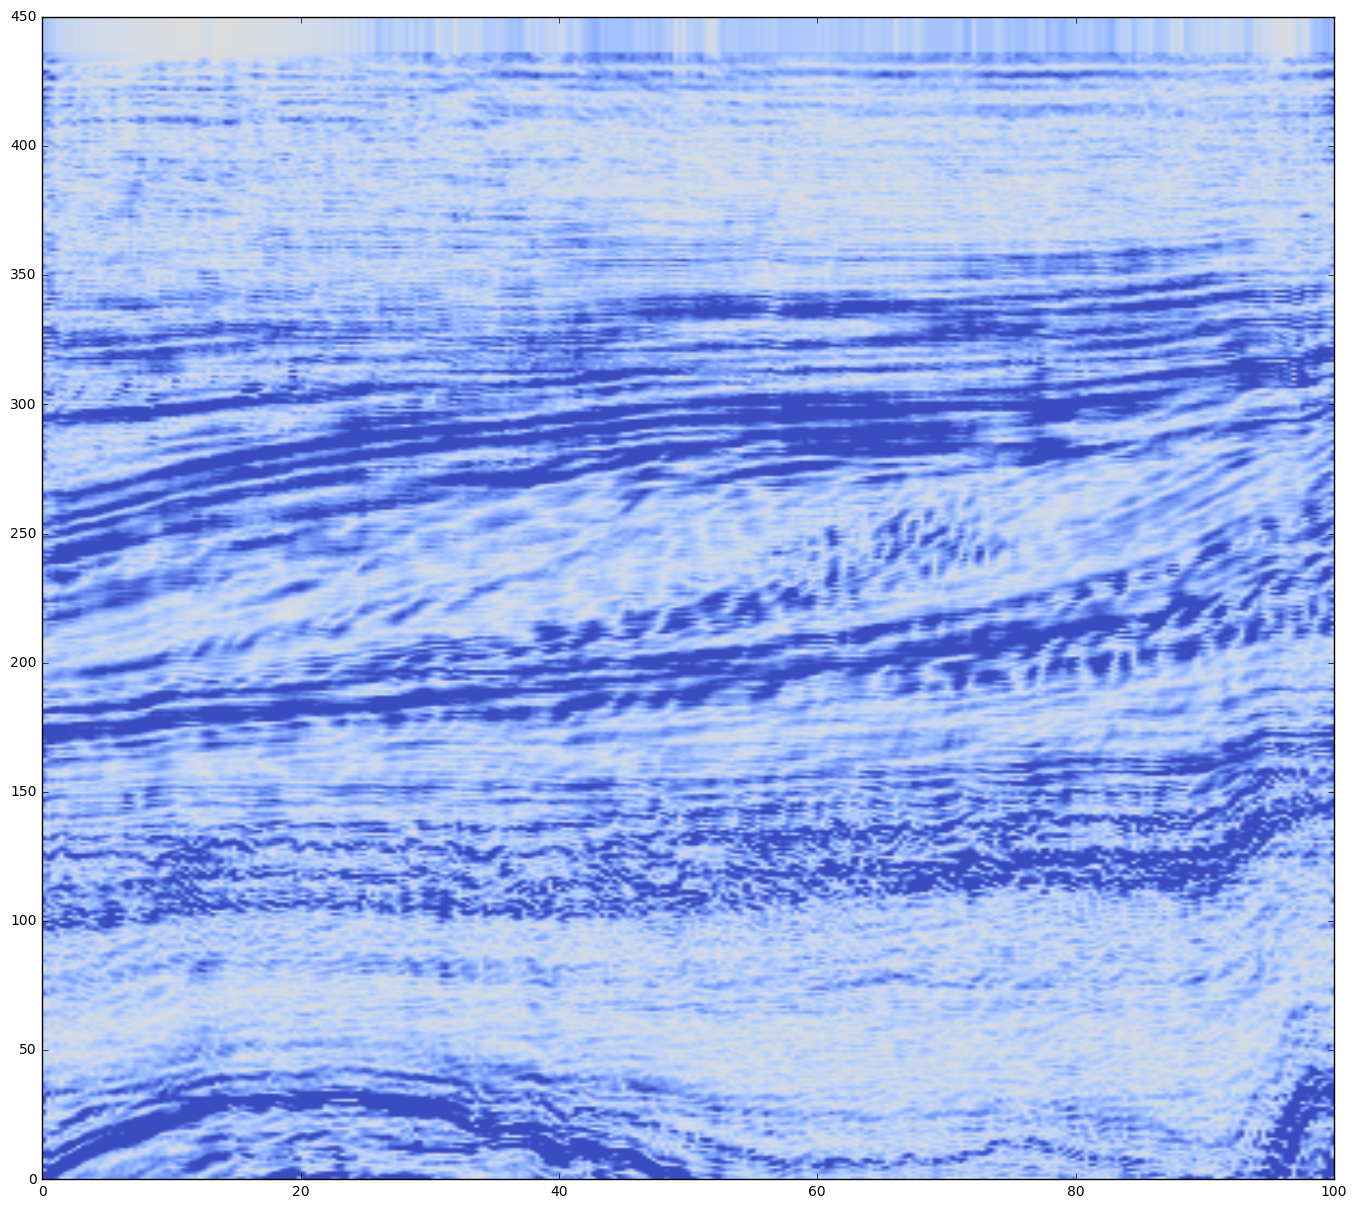

In [67]:
env_line = np.empty_like(line)

for i,trace in enumerate(np.transpose(line)):
    env_line[:,i] = envelope(trace)

fig_envline = plt.figure(figsize = (20, 15), facecolor='white')
ax = fig_envline.add_subplot(111)
imenv = np.transpose(env_line)   # <--- must tranpose for image orientation
im = ax.imshow(imenv, cmap='coolwarm_r', vmin = vmin*0.5, vmax = vmax*0.5,
                extent =  line_ext, 
                aspect = 0.2
                )

 # plot the trace

In [68]:
#
# (Some cumbersome MPL plotting code)
#
ax.plot(x + 10*(e/np.amax(e)), t,'k', alpha = 0.5)
# plot positive values in wiggle trace blue
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(e/np.amax(e)), 
                  x2 = x,
                  where = e > 0,
                  alpha = 0.35,
                  color = 'b')
# plot negative values in wiggle trace red
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(e/np.amax(e)), 
                  x2 = x, 
                  where = e < 0,
                  alpha = 0.35,
                  color = 'r')
                      
# plot zero-crossing of the trace
ax.plot(x*np.ones_like(e), t, 'k', alpha = 0.5)

# create a colorbar axes
colorbar_ax = fig_envline.add_axes([0.15, 0.75, 0.015, 0.1])
# assign the im ScalarMappable to the colorbar
fig_envline.colorbar(im, cax=colorbar_ax)
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, -0.1, 'negative', bbox=dict(facecolor='white', alpha=0.5),
                      transform=colorbar_ax.transAxes,
                      horizontalalignment='center',
                      verticalalignment='top')
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, 1.1, 'positive',
                     transform=colorbar_ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                     horizontalalignment='center')
# turn off the colorbar ticks
colorbar_ax.set_axis_off()

# labels and grids
ax.set_xlim(left = line_ext['first_trace'], right = line_ext['last_trace'])
ax.set_xlabel('offset')
ax.set_ylim(bottom = line_ext['end_time'], top = line_ext['start_time'])
ax.set_ylabel('two-way time [s]')
ax.grid()

NameError: name 'x' is not defined

# Statistical calculations within a moving window. The simplest is energy within a moving window

In [ ]:
from bruges.attribute import energy
window_length = 0.05 # in seconds
eRMS = energy(imline, duration = window_length, dt = 0.004)

x_nrg = eRMS[:,x]

fig_energy = plt.figure(figsize = (20, 15), facecolor='white')
ax = fig_energy.add_subplot(111)

eRMS = energy(imline, duration = 0.05, dt = 0.004)   # <--- must tranpose for image orientation
im = plt.imshow(eRMS, cmap='RdBu', vmin = -1.0*np.amax(eRMS), vmax = np.amax(eRMS),
                extent =  (line_ext['first_trace'], 
                           line_ext['last_trace'], 
                           line_ext['end_time'], 
                           line_ext['start_time']), 
                aspect = 120 
                )

plt.colorbar(shrink=0.25)

# plot the trace
#
# (Some cumbersome MPL plotting code)
#
ax.plot(x + 10*(x_nrg/np.amax(x_nrg)), t,'k', alpha = 0.5)
# plot positive values in wiggle trace blue
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(x_nrg/np.amax(x_nrg)), 
                  x2 = x,
                  where = x_nrg > 0,
                  alpha = 0.35,
                  color = 'b')
# plot negative values in wiggle trace red
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(x_nrg/np.amax(x_nrg)), 
                  x2 = x, 
                  where = x_nrg < 0,
                  alpha = 0.35,
                  color = 'r')
                      
# plot zero-crossing of the trace
ax.plot(x*np.ones_like(x_nrg), t, 'k', alpha = 0.5)

# create a colorbar axes
colorbar_ax = fig_envline.add_axes([0.15, 0.75, 0.015, 0.1])
# assign the im ScalarMappable to the colorbar
fig_energy.colorbar(im, cax=colorbar_ax)
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, -0.1, 'negative', bbox=dict(facecolor='white', alpha=0.5),
                      transform=colorbar_ax.transAxes,
                      horizontalalignment='center',
                      verticalalignment='top')
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, 1.1, 'positive',
                     transform=colorbar_ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                     horizontalalignment='center')
# turn off the colorbar ticks
colorbar_ax.set_axis_off()

# labels and grids
ax.set_xlim(left = line_ext['first_trace'], right = line_ext['last_trace'])
ax.set_xlabel('offset')
ax.set_ylim(bottom = line_ext['end_time'], top = line_ext['start_time'])
ax.set_ylabel('two-way time [s]')
w_ms = 1000.0*window_length
ax.set_title('Average Energy Attribute (%d ms window averaging)' % w_ms)
ax.grid()